# RoPE embeddings

In [2]:
import torch
import matplotlib.pyplot as plt

In [24]:
def compute_freqs(dim: int, theta: float = 10000.0):
    return 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    # freqs: (dim // 2,)
    freqs = compute_freqs(dim, theta)
    # t: (end,)
    t = torch.arange(end)
    # freqs: (end, dim // 2)
    freqs = torch.outer(t, freqs).float()
    # freqs_cis: (end, dim // 2)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

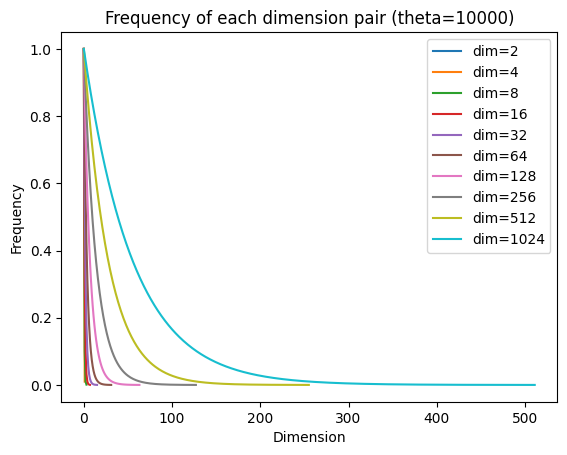

In [29]:
# Plot the freqs for various dims
theta = 10000
for dim_power in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dim = 2**dim_power
    freqs = compute_freqs(dim, theta)
    plt.plot(freqs, label=f"dim={dim}")
plt.title("Frequency of each dimension pair (theta=10000)")
plt.xlabel("Dimension")
plt.ylabel("Frequency")
plt.legend()
plt.show()


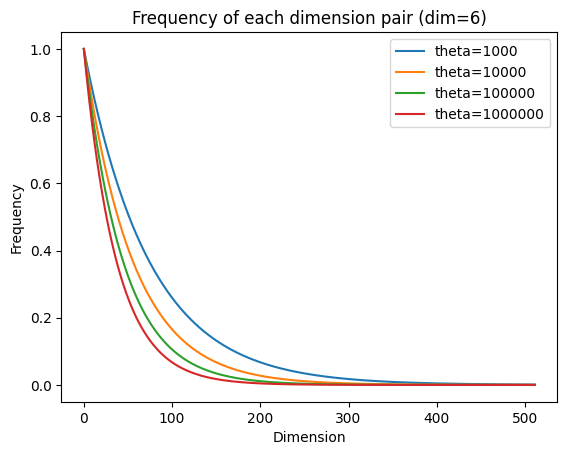

In [31]:
# Plot freqs for various theta for a given dim
dim = 1024
for theta in [1000, 10000, 100000, 1000000]:
    freqs = compute_freqs(dim, theta)
    plt.plot(freqs, label=f"theta={theta}")
plt.title("Frequency of each dimension pair (dim=6)")
plt.xlabel("Dimension")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [22]:
dim = 6
end = 4
theta = 10000
# 1. compute the frequencies for each pair of dimensions
# Since we
# First Get [0, 2, .., dim-(2 if dim is even else 3)]
freqs_1 = torch.arange(0, dim, 2)
print(f"{freqs_1=}")
# This line handles the case where dim is odd
freqs_2 = freqs_1[: (dim // 2)]
print(f"{freqs_2=}")
# Convert into [0, 1] interval
freqs_3 = freqs_2.float() / dim
print(f"{freqs_3=}")
# Finally compute the frequency for each dim by scaling by theta
freqs_4 = 1.0 / (theta ** (freqs_3))
print(f"{freqs_4=}")
# 2. generate the rotation matrix (T, dim // 2)
t = torch.arange(end)
freqs_5 = torch.outer(t, freqs_4)
print(f"{freqs_5.shape=}")
print(f"{freqs_5=}")
freqs_6 = torch.polar(torch.ones_like(freqs_5), freqs_5)
print(f"{freqs_6.shape=}")
print(f"{freqs_6=}")


freqs_1=tensor([0, 2, 4])
freqs_2=tensor([0, 2, 4])
freqs_3=tensor([0.0000, 0.3333, 0.6667])
freqs_4=tensor([1.0000, 0.0464, 0.0022])
freqs_5.shape=torch.Size([4, 3])
freqs_5=tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.6416e-02, 2.1544e-03],
        [2.0000e+00, 9.2832e-02, 4.3089e-03],
        [3.0000e+00, 1.3925e-01, 6.4633e-03]])
freqs_6.shape=torch.Size([4, 3])
freqs_6=tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9989+0.0464j,  1.0000+0.0022j],
        [-0.4161+0.9093j,  0.9957+0.0927j,  1.0000+0.0043j],
        [-0.9900+0.1411j,  0.9903+0.1388j,  1.0000+0.0065j]])


x.shape=torch.Size([8, 1])
x.shape=torch.Size([8, 2])
x.shape=torch.Size([8, 4])
x.shape=torch.Size([8, 8])
x.shape=torch.Size([8, 16])
x.shape=torch.Size([8, 32])
x.shape=torch.Size([8, 64])
x.shape=torch.Size([8, 128])
x.shape=torch.Size([8, 256])
x.shape=torch.Size([8, 512])


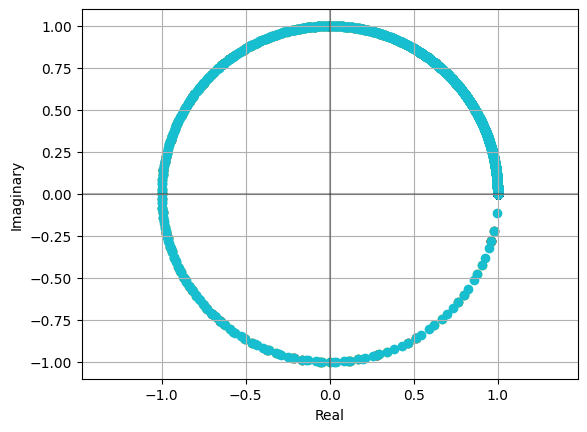

In [32]:
# Plot the freqs_cis for various dim sizes for a given sequence length
for dim_power in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dim = 2**dim_power
    x = precompute_freqs_cis(dim, 8, theta=10000)
    print(f"{x.shape=}")

    # # plot the frequency tensor
    plt.scatter(x.real, x.imag, label=f"dim={dim}")

plt.grid(True)
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="k", linestyle="-", alpha=0.3)
plt.xlabel("Real")
plt.ylabel("Imaginary")

# Make axes equal to preserve the shape
plt.axis("equal")
plt.show()


In [ ]:
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor]:
    # xq: (B, T, n_head, d_head)
    # xk: (B, T, n_kv_head, d_head)
    # freqs_cis: (T, d_head)

    # reshape to complex numbers
    # TODO check if we need the .float() here
    # (B, T, n_head, d_head) -> (B, T, n_head, d_head // 2, 2)
    xq = xq.float().reshape(*xq.shape[:-1], -1, 2)
    # (B, T, n_kv_head, d_head) -> (B, T, n_kv_head, d_head // 2, 2)
    xk = xk.float().reshape(*xk.shape[:-1], -1, 2)
    # convert to complex numbers
    xq_ = torch.view_as_complex(xq)
    xk_ = torch.view_as_complex(xk)

    # reshape for broadcasting
    ndim = xq.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (xq.shape[1], xq.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(xq.shape)]
    freqs_cis = freqs_cis.view(*shape)

    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)